## Logistic Regression

In [110]:
### Libraries to be imported
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

In [111]:
### Dataset we will be using
data = pd.read_csv('../Datasets/featured.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head(5)

,Source Port,Destination Port,Packet Length,Packet Type,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Signature,is_weekend,Is_Private,...,cos_weekly_day,monthly_sin,monthly_cos,Registered_Ports,Ephemeral_Ports,Is_Malware_Port,is_morning,is_afternoon,is_evening,is_night
0,31225,17616,503,1,1,28.67,1,0,0,0,...,0.623490,0.500000,-0.866025,1,0,0,1,0,0,0
1,17245,48166,1174,1,1,51.50,1,1,0,0,...,-0.222521,-0.866025,-0.500000,1,0,0,0,1,0,0
2,16811,53600,306,0,1,87.42,0,0,1,0,...,0.623490,-0.500000,0.866025,0,1,0,0,1,0,0
3,20018,32534,385,1,0,15.79,0,0,1,0,...,0.623490,-0.500000,-0.866025,1,0,0,0,1,0,0
4,6131,26646,1462,1,0,0.52,0,0,1,0,...,0.623490,-0.500000,-0.866025,1,0,0,0,0,0,0


In [112]:
### Training and Testing dataset 
X = data.drop('Malware Indicators', axis = 1)
y = data['Malware Indicators']
RANDOM_SEED = 13
X_train, X_test, y_train , y_test = train_test_split(X,y , test_size=0.2, random_state=RANDOM_SEED)

### In this notebook we will be comparing the logisitc regression and hypertuned logistic regression, based on the outcome required we will be doing threshold tunning to get the perfect output

The training accuracy of the model is 51.10 % and the testing accuracy of the model is 49.99 %
The precision score of the logit model is 0.50, meaning out of the predicted values 49.97% were right
The recall score of the logit model is 0.49, meaning out of all the positive cases the model predicted 48.66% right
The harmonic mean between precision and recall was 0.49%
The false negative rate of the model is 51.34% out of all the positive cases


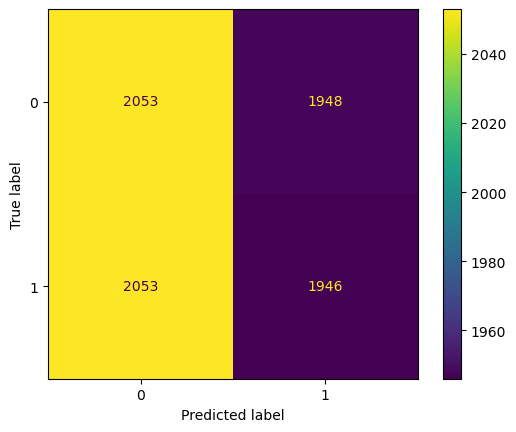

In [113]:
### Basic Logistic Regression Model 
pipeline_steps = [('scalar',StandardScaler()), ('logit_model', LogisticRegression())]
pretuned_model = Pipeline(pipeline_steps)

pretuned_model.fit(X_train,y_train)

training_pred = pretuned_model.predict(X_train)
testing_pred = pretuned_model.predict(X_test)
training_proba = pretuned_model.predict_proba(X_train)[:,1]
testing_proba = pretuned_model.predict_proba(X_test)[:,1]

### Evaluating the model 

training_accuracy_score = accuracy_score(y_train, training_pred)
testing_accuracy_score = accuracy_score(y_test, testing_pred)
print(f"The training accuracy of the model is {training_accuracy_score* 100:.2f} % and the testing accuracy of the model is {testing_accuracy_score* 100:.2f} %")

## Calculating precision, recall, and f1-score

precision = precision_score(y_test, testing_pred)
print(f"The precision score of the logit model is {precision:.2f}, meaning out of the predicted values {precision*100:.2f}% were right")
recall = recall_score(y_test, testing_pred)
print(f"The recall score of the logit model is {recall:.2f}, meaning out of all the positive cases the model predicted {recall*100:.2f}% right")

f1 = f1_score(y_test, testing_pred)
print(f"The harmonic mean between precision and recall was {f1:.2f}%")
roc_value = roc_auc_score(y_test, testing_proba)

fpr,tpr, threshold = roc_curve(y_test,testing_proba)
### Confusion Matrix and plotting the confusion matrix 

evaluation_matrix = confusion_matrix(y_test, testing_pred)
true_negatives, false_positives, false_negatives, true_positives = confusion_matrix(y_test,testing_pred).ravel()

### False Negative Rate: 
false_negative_rate = false_negatives/(false_negatives+ true_positives)
print(f"The false negative rate of the model is {false_negative_rate *100:.2f}% out of all the positive cases")
display = ConfusionMatrixDisplay(confusion_matrix=evaluation_matrix)
display.plot()



### As we can see from the model's performance, the precision, recall, and f1 score of the model < 50%, whereas the true positives and true negatives have the similar score as of false negatives and false positives. 

### Since we are programming a model which does better on detecting malware on the basis of the given feature, we need to make sure that the false negatives or the values which are incorrectly misclassified be decreased and the recall score be increased

### For this process we will be implementing 1.Hyperparameter tuning and 2.Threshold tuning



In [114]:
## Here we first scale the data, then we apply the Logistic Regression model 
pipeline_steps = [('scaler', StandardScaler()), ('model', LogisticRegression(solver= 'liblinear', max_iter=1000, class_weight='balanced'))]
logit_model = Pipeline(pipeline_steps)
## We set the parameters, "C": Regularization Parameter, and the model penalties being 'l1' and 'l2'
params = {"model__C":[0.001,0.01,0.1,10,100,1000],"model__penalty":['l1','l2']}
## We use the StratifiedKFold in order to make sure that there is no class imbalance
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_SEED)
## We use Grid Search CV to test out all the possible combination of hyperparameters that we have
hyperparameter_tuning = GridSearchCV(logit_model, param_grid=params, cv = kf, n_jobs = -1, scoring = 'f1')
hypertune_logit_model = hyperparameter_tuning.fit(X_train,y_train)
## This will be the model that we will be using
tuned_logit_model = hypertune_logit_model.best_estimator_




/opt/anaconda3/envs/CyberSecurityProject/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/CyberSecurityProject/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/opt/anaconda3/envs/CyberSecurityProject/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_

0.51146875
0.5
0.49987110079917507
0.48487121780445114
0.4922569179994923


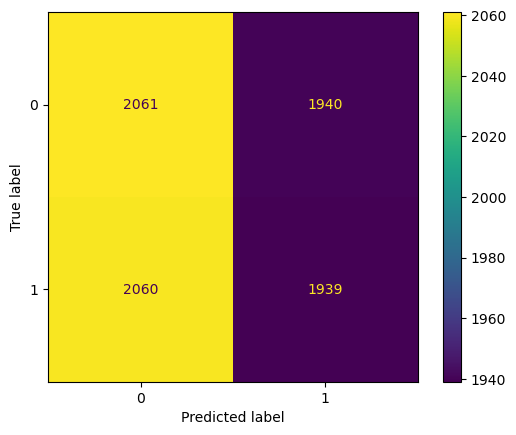

In [115]:
## This is where we evaluate our hypertuned model and its performance

## Lets evaluate our hypertuned model 
tuned_training_pred = hypertune_logit_model.predict(X_train)
tuned_testing_pred = hypertune_logit_model.predict(X_test)
tuned_training_proba = hypertune_logit_model.predict(X_train)
tuned_testing_proba = hypertune_logit_model.predict(X_test)

## Lets compute the accuracy scores for the model

training_accuracy_score = accuracy_score(y_train, tuned_training_pred)
print(training_accuracy_score)
testing_accuracy_score = accuracy_score(y_test, tuned_testing_pred)
print(testing_accuracy_score)

### Precision, Recall, F1_Score: 

precision = precision_score(y_test, tuned_testing_pred)
print(precision)
recall = recall_score(y_test, tuned_testing_pred)
print(recall)
f1 = f1_score(y_test, tuned_testing_pred)
print(f1)

## Evaluation Matrix 
evaluation_matrix = confusion_matrix(y_test, tuned_testing_pred)
display = ConfusionMatrixDisplay(confusion_matrix=evaluation_matrix)
display.plot()

### Lets do the threshold tuning in order to maximize the model's recall so that we don't miss out any of the malware cases.